In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
import math
import pandas as pd
import seaborn as sns
import shutil

from keras import preprocessing, optimizers, utils, layers, models, regularizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

%matplotlib inline

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Who's Who in the Fungi Kingdom

*Objective:* We will use transfer learning in deep learning to classify images of mushrooms into 9 most common Northern European genus types: Agaricus, Amanita, Boletus, Cortinarius, Entoloma, Hygrocybe, Lactarius, Russula, Suillus. 

The images used in this project were obtained from [Kaggle](https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images).

We will choose ResNet50 as the base architecture, but [other options](https://github.com/keras-team/keras-applications) we tried include InceptionV3 and VGG16.

## Define the parameters of our model

List the mushroom genera, which are the classes we'll be working with.

In [18]:
image_dir = '../input/mushrooms-classification-common-genuss-images/mushrooms/Mushrooms/'
g_type_list = [x.split('/')[-1] for x in glob.glob(os.path.join(image_dir, '[A-Z]*'))]
print(g_type_list)

['Entoloma', 'Agaricus', 'Lactarius', 'Hygrocybe', 'Boletus', 'Suillus', 'Cortinarius', 'Russula', 'Amanita']


Choose the base model for transfer learning.

In [19]:
arch = 'resnet50'

Define variables we will be using later on.

In [20]:
num_classes = len(g_type_list)
print('{:<20}'.format('Mushroom Genuses:')+'{:>90}'.format(', '.join(g_type_list)))
print('{:<40}'.format('Number of Mushroom Genuses/Classes:')+'{:>70}'.format('{:2n}'.format(num_classes)))

if (arch == 'resnet50') | (arch == 'vgg16'):
    image_size = 224
elif (arch == 'inceptionv3'):
    image_size = 299
batch_size = 32
print('-'*110)
print('{:<40}'.format('Input Image:')+'{:>70}'.format('{:3n} x {:3n} x {:1n}'.format(*[image_size, image_size, 3])))
print('{:<40}'.format('Batch Size:')+'{:>70}'.format('{:2n}'.format(batch_size)))

n_images = len(glob.glob(os.path.join(image_dir, '*/*jpg')))
train_val_split = 0.2
n_val = int(n_images*train_val_split)
n_train = n_images - n_val
print('-'*110)
print('{:<50}'.format('Total Number of Pre-Augmented Training Images:')+'{:>60}'.format('{:3n}'.format(n_train)))
print('{:<50}'.format('Total Number of Validation Images:')+'{:>60}'.format('{:3n}'.format(n_val)))

Mushroom Genuses:    Entoloma, Agaricus, Lactarius, Hygrocybe, Boletus, Suillus, Cortinarius, Russula, Amanita
Number of Mushroom Genuses/Classes:                                                                          9
--------------------------------------------------------------------------------------------------------------
Input Image:                                                                                     224 x 224 x 3
Batch Size:                                                                                                 32
--------------------------------------------------------------------------------------------------------------
Total Number of Pre-Augmented Training Images:                                                            5372
Total Number of Validation Images:                                                                        1342


## Set up the model architecture

We will use the ResNet50 architecture as the base model. We read in the pre-trained weights and skip the fully-connected output layers by setting ``include_top=False``.

In [21]:
if (arch == 'inceptionv3'):
    inceptionv3_weights = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base = InceptionV3(weights=inceptionv3_weights, include_top=False, input_shape=(image_size, image_size, 3))
    preprocess_input = inceptionv3_preprocess_input

if (arch == 'resnet50'):
    resnet50_weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base = ResNet50(weights=resnet50_weights, include_top=False, input_shape=(image_size, image_size, 3))
    preprocess_input = resnet50_preprocess_input

if (arch == 'vgg16'):
    vgg16_weights = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base = VGG16(weights=vgg16_weights, include_top=False, input_shape=(image_size, image_size, 3))
    preprocess_input = vgg16_preprocess_input

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


The first thing we did was to freeze all of the pretrained layers and only train our own fully-connected layers on top. However, there was a severe bias problem that could not be resolved even with a combination of different base architectures and the choice of output layers and/or optimizers. So instead, we'll freeze *most* of the pretrained layers (everything excluding the last two residual blocks), and train the unfrozen layers along with the fully-connected layers on top.

In [22]:
if arch == 'resnet50':
    for layer in base.layers[:-11]:
        layer.trainable = False
    
X = base.output
X = GlobalAveragePooling2D()(X)
X = BatchNormalization()(X)

X = Dense(100, activation=None, kernel_regularizer=regularizers.l2(0.05))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.3)(X) #this version on Kaggle uses keep_prob instead of rate

X = Dense(100, activation=None, kernel_regularizer=regularizers.l2(0.05))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.3)(X)

X = Dense(num_classes, activation=None)(X)
X = BatchNormalization()(X)
Y = Activation('softmax')(X)

model = models.Model(inputs=base.input, outputs=Y)

for layer in model.layers:
    print(layer.name, layer.trainable)


input_2 False
conv1_pad False
conv1 False
bn_conv1 False
activation_53 False
pool1_pad False
max_pooling2d_2 False
res2a_branch2a False
bn2a_branch2a False
activation_54 False
res2a_branch2b False
bn2a_branch2b False
activation_55 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_17 False
activation_56 False
res2b_branch2a False
bn2b_branch2a False
activation_57 False
res2b_branch2b False
bn2b_branch2b False
activation_58 False
res2b_branch2c False
bn2b_branch2c False
add_18 False
activation_59 False
res2c_branch2a False
bn2c_branch2a False
activation_60 False
res2c_branch2b False
bn2c_branch2b False
activation_61 False
res2c_branch2c False
bn2c_branch2c False
add_19 False
activation_62 False
res3a_branch2a False
bn3a_branch2a False
activation_63 False
res3a_branch2b False
bn3a_branch2b False
activation_64 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_20 False
activation_65 False
res3b_branch2a False
bn

This is our complete model architecture. There are only about 9 million training parameters.

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Compile the model. We'll be using the Adam optimizer using the default learning rate of 0.001. This is a popular option that combines two other methods, RMSprop and momentum.

In [24]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.adam(), metrics=['accuracy'])

## Preprocess the images
We will use ``ImageDataGenerator`` to create batches of data with real-time data augmentation during training. We could use this to generate new images if we want. We supply ResNet50's ``preprocess_input`` function to ensure that we preprocess our input training images the same way the images originally used to train ResNet50 were preprocessed.

In [25]:
do = True
if do:    
    # Create the training and validation image directories
    if not os.path.isdir('images'):
         os.mkdir('images')
    if not os.path.isdir('images/training'):
         os.mkdir('images/training')
    if not os.path.isdir('images/validation'):
         os.mkdir('images/validation')
    
    # Create genus subdirectories in training and validation directories.
    for g_type in g_type_list:
        g_train_path = os.path.join('images/training', g_type)
        g_val_path = os.path.join('images/validation', g_type)
    
        if not os.path.isdir(g_train_path):
            os.mkdir(g_train_path)
        if not os.path.isdir(g_val_path):
            os.mkdir(g_val_path)
        
        # Split the images randomly into training and validation sets.
        img_list = glob.glob(os.path.join(image_dir, g_type)+'/*jpg')
        ind_list = list(np.arange(0, len(img_list)))
        val_ind_list = random.sample(ind_list, int(train_val_split*len(ind_list)))
        train_ind_list = [ind_list[i] for i in range(len(ind_list)) if ind_list[i] not in val_ind_list]
        
        # Make sure that the splitting was done correctly.
        assert sorted(ind_list) == sorted(val_ind_list + train_ind_list)
        
        # Move the images.
        for img in img_list:
            if img_list.index(img) in val_ind_list:
                shutil.copy(img, os.path.join(g_val_path, img.split('/')[-1]))
            else:
                shutil.copy(img, os.path.join(g_train_path, img.split('/')[-1]))

Augment *only* the training set. In many of the photos, the mushrooms are positioned right near the edge. This causes horizontal/vertical shift, shear and rotation to introduce artificial features due to extrapolation/filling in the mushrooms. We'll only use zoom and flips.

In [26]:
train_idg = preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input, 
                                                    zoom_range=0.3,
                                                    width_shift_range=0.2, height_shift_range=0.2, rotation_range=30, shear_range=0.2,
                                                    horizontal_flip=True,
                                                    vertical_flip=True)

val_idg = preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_idg.flow_from_directory(
        'images/training',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_generator = val_idg.flow_from_directory(
        'images/validation',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 6438 images belonging to 9 classes.
Found 2402 images belonging to 9 classes.


Mushroom genuses are mapped to the class labels as follows.

In [27]:
print(val_generator.class_indices)

{'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


## Inspect the Input Data

Let's check some random images (pre-processed) for each genus type. To my untrained eyes, the all of the mushrooms look very similar.

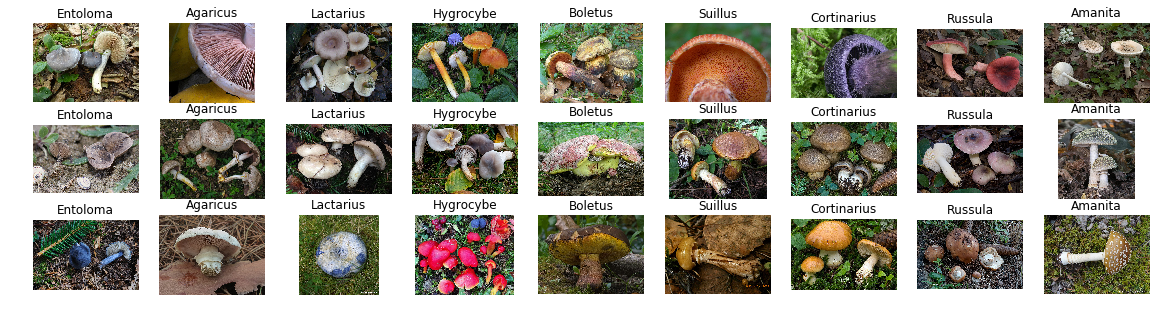

In [28]:
num_per_genus = 3
random_images = []
random_images_labels = []

for g in g_type_list:
    g_img_list = glob.glob(os.path.join(image_dir, g+'/*jpg'))
    num_img = len(g_img_list)
    rand_img_ind = random.sample(list(np.arange(0, num_img)), num_per_genus)
    random_images += [g_img_list[i] for i in rand_img_ind]
    random_images_labels += [g]*num_per_genus

f, ax = plt.subplots(num_per_genus, num_classes, figsize=(20,5))
for i, sample in enumerate(random_images):
    ax[i%num_per_genus, i//num_per_genus].imshow(plt.imread(sample))
    ax[i%num_per_genus, i//num_per_genus].axis('off')
    ax[i%num_per_genus, i//num_per_genus].set_title(random_images_labels[i])

plt.show()    

We will also check the distribution of labels.

Our training and validation set indeed have same distribution of class labels. Classes are decently well balanced. The largest discrepancy is between classes 5 and 6 (Hygrocybe and Amanita), at around 20%.

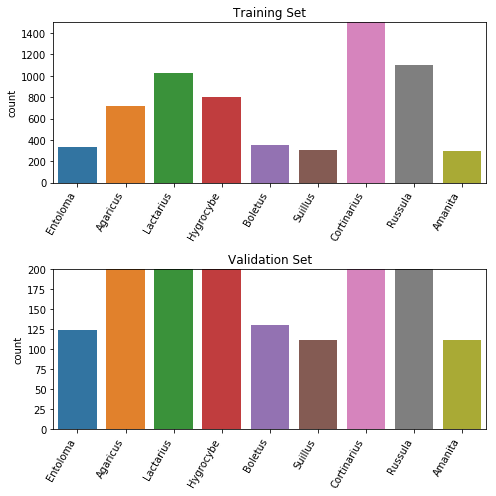

In [29]:
training_df = pd.DataFrame(train_generator.classes, columns=['classes'])
val_df = pd.DataFrame(val_generator.classes, columns=['classes'])

plt.figure(1, figsize=(7, 7))

for i in range(2):
    if i == 0:
        df = training_df
        ax = plt.subplot(211)

    else:
        df = val_df
        ax = plt.subplot(212)

    s = sns.countplot(x='classes', data=df, ax=ax)
    _ = plt.xticks(s.get_xticks(), g_type_list, rotation=60, ha='right')
    s.set_xlabel(None)
    if i == 0:
        _ = s.set_title('Training Set')
        s.set_ylim(0, 1500)
    else:
        _ = s.set_title('Validation Set')
        s.set_ylim(0, 200)
plt.tight_layout()

## Train the model

We use early stopping to help fight overfitting. Training stops when ``val_loss`` stops improving over 10 steps.

In [30]:
checkpoint = ModelCheckpoint('weights.best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5)

history = model.fit_generator(train_generator,\
                                  steps_per_epoch=math.ceil(n_train/batch_size)*1.5,\
                                  epochs=50,\
                                  validation_data=val_generator,\
                                  validation_steps=math.ceil(n_val/batch_size),\
                                  callbacks=[checkpoint, earlystop])


Epoch 1/50
252/252 [==============================] - 180s 712ms/step - loss: 5.0410 - acc: 0.5396 - val_loss: 2.3644 - val_acc: 0.4427

Epoch 00001: val_acc improved from -inf to 0.44271, saving model to weights.best.hdf5
Epoch 2/50
252/252 [==============================] - 165s 655ms/step - loss: 1.4456 - acc: 0.6693 - val_loss: 1.4832 - val_acc: 0.5989

Epoch 00002: val_acc improved from 0.44271 to 0.59893, saving model to weights.best.hdf5
Epoch 3/50
252/252 [==============================] - 168s 667ms/step - loss: 1.2387 - acc: 0.7061 - val_loss: 1.1358 - val_acc: 0.7158

Epoch 00003: val_acc improved from 0.59893 to 0.71577, saving model to weights.best.hdf5
Epoch 4/50
252/252 [==============================] - 167s 661ms/step - loss: 1.1521 - acc: 0.7378 - val_loss: 1.2214 - val_acc: 0.6804

Epoch 00004: val_acc did not improve from 0.71577
Epoch 5/50
252/252 [==============================] - 167s 665ms/step - loss: 1.0888 - acc: 0.7489 - val_loss: 1.3318 - val_acc: 0.6696

E

Let's plot training & validation accuracy values and losses.

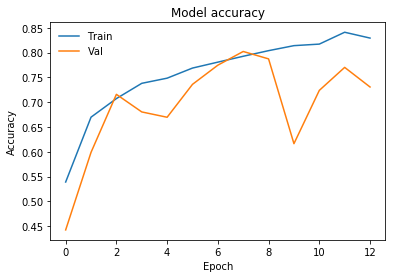

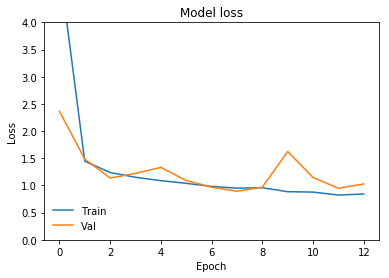

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
leg = plt.legend(['Train', 'Val'], loc=2, frameon=False)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc=3, frameon=False)
plt.ylim(0,4)
plt.show()

Save the model for future use.

In [32]:
model.save('mushroom_resnet50.h5')